In [4]:
%run -i '../scripts/py/config.py'

In [1]:
%run -i '../scripts/py/my_utils.py'

In [44]:
%run -i '../scripts/py/networking.py'

In [ ]:
from datetime import datetime

### Open Saved Graph

In [32]:
filename='5K_Drive.graphml'
G = LoadSavedGraph(filename)

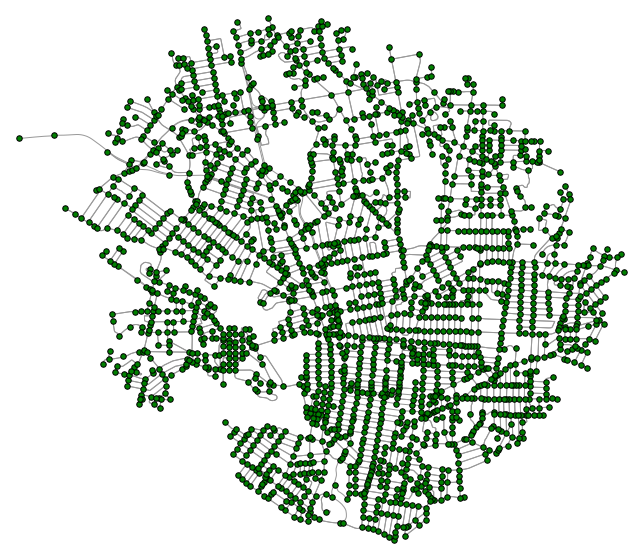

In [8]:
fig, ax = plot_graph_mls(G, 
                         fig_height=10, 
                         node_color='green',
                         node_size=30, 
                         node_zorder=2, 
                         node_edgecolor='k')

### Open Hourly Traffic Count Data

In [24]:
'''
Open camera locations
'''

camlocs = pd.read_csv(GetCamFolder()+'/'+'CameraLocations.csv',)

camlocs

,camid,Main,Cross,Direction,osmid
0,200,Government St.,Belleville St.,North,26823672
1,498,Vernon Ave.,Cloverdale Ave.,North,25841055
2,499,Vernon Ave.,Cloverdale Ave.,South,25841055
3,507,Blanshard St.,Sannich Rd.,North,25841022
4,508,Blanshard St.,Sannich Rd.,South,25841022
5,509,Blanshard St.,Sannich Rd.,East,25841022
6,510,Blanshard St.,Sannich Rd.,West,25841022
7,511,Vernon Ave.,Sannich Rd.,North,25841021
8,512,Vernon Ave.,Sannich Rd.,South,25841021
9,513,Vernon Ave.,Sannich Rd.,East,25841021


In [33]:
'''
Open traffic counts

Add rounded time for each, Ex. 2019-01-01 01:00
'''

month = 10
day = 11
hour = 11

filename = GetImageRoot(month,day,hour)+'/'+'traffic_measurement.csv'
# print(GetImageRoot(month,day,hour))

images = pd.read_csv(filename)
images = images.drop('Unnamed: 10',axis=1)

images['camid'] = images['ImagePath'].map(lambda x: x[-9:-6])
images['camid'] = images['camid'].astype(int)

images = images.sort_values('camid')

images.head()

,ImagePath,NumDetections,bicycle,car,motorcycle,airplane,bus,train,truck,boat,camid
0,../data/cameras/M10/D11/H11/C498/498_1.jpg,4,0,4,0,0,0,0,0,0,498
1,../data/cameras/M10/D11/H11/C498/498_2.jpg,6,0,6,0,0,0,0,0,0,498
2,../data/cameras/M10/D11/H11/C498/498_3.jpg,5,0,5,0,0,0,0,0,0,498
3,../data/cameras/M10/D11/H11/C498/498_4.jpg,6,0,6,0,0,0,0,0,0,498


In [56]:
images['DATE_PST'] = datetime(2019,month,day,hour)
images.head()

,ImagePath,NumDetections,bicycle,car,motorcycle,airplane,bus,train,truck,boat,camid,DATE_PST
0,../data/cameras/M10/D11/H11/C498/498_1.jpg,4,0,4,0,0,0,0,0,0,498,2019-10-11 11:00:00
1,../data/cameras/M10/D11/H11/C498/498_2.jpg,6,0,6,0,0,0,0,0,0,498,2019-10-11 11:00:00
2,../data/cameras/M10/D11/H11/C498/498_3.jpg,5,0,5,0,0,0,0,0,0,498,2019-10-11 11:00:00
3,../data/cameras/M10/D11/H11/C498/498_4.jpg,6,0,6,0,0,0,0,0,0,498,2019-10-11 11:00:00


In [55]:


datetime(2019,month,day,hour)

datetime.datetime(2019, 10, 11, 11, 0)

In [57]:
'''
merge osmid into traffic counts
'''

merged = images.merge(camlocs,on='camid')
merged.head()

,ImagePath,NumDetections,bicycle,car,motorcycle,airplane,bus,train,truck,boat,camid,DATE_PST,Main,Cross,Direction,osmid
0,../data/cameras/M10/D11/H11/C498/498_1.jpg,4,0,4,0,0,0,0,0,0,498,2019-10-11 11:00:00,Vernon Ave.,Cloverdale Ave.,North,25841055
1,../data/cameras/M10/D11/H11/C498/498_2.jpg,6,0,6,0,0,0,0,0,0,498,2019-10-11 11:00:00,Vernon Ave.,Cloverdale Ave.,North,25841055
2,../data/cameras/M10/D11/H11/C498/498_3.jpg,5,0,5,0,0,0,0,0,0,498,2019-10-11 11:00:00,Vernon Ave.,Cloverdale Ave.,North,25841055
3,../data/cameras/M10/D11/H11/C498/498_4.jpg,6,0,6,0,0,0,0,0,0,498,2019-10-11 11:00:00,Vernon Ave.,Cloverdale Ave.,North,25841055


In [67]:
'''
Get count of vehicle types by node
'''

counts = merged.groupby('osmid').sum()

cols = ['bicycle', 'car', 'motorcycle',
       'bus', 'train', 'truck']
counts = counts[cols]

counts.reset_index(drop=False,inplace=True)

# counts['DATE_PST'] = datetime(2019,month,day,hour)
# counts.head()

counts

,osmid,bicycle,car,motorcycle,bus,train,truck,DATE_PST
0,25841055,0,21,0,0,0,0,2019-10-11 11:00:00


In [68]:
'''
Determine emission load at interesction
'''

cols = ['bicycle', 'car', 'motorcycle',
       'bus', 'train', 'truck']

values = [0,1,3,4,5,6]

combos = dict(zip(cols,values))

rows = counts.index.tolist() 
for row in rows:
    for col in cols:
#         print(col,counts.at[row,col],counts.at[row,col]*combos[col])
        counts.at[row,col] = int(counts.at[row,col]*combos[col])
counts

,osmid,bicycle,car,motorcycle,bus,train,truck,DATE_PST
0,25841055,0,21,0,0,0,0,2019-10-11 11:00:00


In [69]:
# Get edges

nodes = GraphToFrames(G)[0]
nodes.head()

,y,x,osmid,lon,lat,geometry,highway,ref
25938318,5.361491e+06,474015.500907,25938318,-123.3511029,48.4060426,POINT (474015.501 5361491.317),NaN,NaN
25938316,5.361543e+06,473937.142452,25938316,-123.3521649,48.4065087,POINT (473937.142 5361543.487),NaN,NaN
25938339,5.361562e+06,474190.359629,25938339,-123.3487446,48.4066857,POINT (474190.360 5361562.003),NaN,NaN
277054133,5.361556e+06,474027.993424,277054133,-123.3509381,48.4066239,POINT (474027.993 5361555.875),NaN,NaN
25938317,5.361592e+06,473856.569600,25938317,-123.3532566,48.40694,POINT (473856.570 5361591.799),NaN,NaN


In [61]:
# Get edges

edges = GraphToFrames(G)[1]
edges.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,ref,bridge,junction
0,25938318,25938316,0,139617961,Dallas Road,secondary,50,False,93.976,"LINESTRING (474015.501 5361491.317, 473937.142...",NaN,NaN,NaN,NaN
1,25938318,277054133,0,139617995,Moss Street,residential,50,False,65.772,"LINESTRING (474015.501 5361491.317, 474027.993...",NaN,NaN,NaN,NaN
2,25938316,25938313,0,4676343,Howe Street,residential,NaN,False,357.477,"LINESTRING (473937.142 5361543.487, 474000.117...",NaN,NaN,NaN,NaN
3,25938316,25938318,0,139617961,Dallas Road,secondary,50,False,93.976,"LINESTRING (473937.142 5361543.487, 474015.501...",NaN,NaN,NaN,NaN
4,25938316,25938317,0,139617961,Dallas Road,secondary,50,False,93.776,"LINESTRING (473937.142 5361543.487, 473856.570...",NaN,NaN,NaN,NaN


In [73]:
'''
Add emission load to nodes
'''

cols = ['bicycle', 'car', 'motorcycle',
       'bus', 'train', 'truck']

for col in cols:
    nodes[col] = 0
    nodes[col] = nodes[col].astype(int)

# Call to add counts to nodes df
nodes['osmid'].map(lambda x: LoadNodeCounts(x))
    
# nodes['osmid'] = nodes['osmid'].astype(int)
    
nodes['DATE_PST'] = datetime(2019,month,day,hour)
nodes.head()

nodes.head()

,y,x,osmid,lon,lat,geometry,highway,ref,bicycle,car,motorcycle,bus,train,truck,DATE_PST
25938318,5.361491e+06,474015.500907,25938318.0,-123.3511029,48.4060426,POINT (474015.501 5361491.317),NaN,NaN,0,0,0,0,0,0,2019-10-11 11:00:00
25938316,5.361543e+06,473937.142452,25938316.0,-123.3521649,48.4065087,POINT (473937.142 5361543.487),NaN,NaN,0,0,0,0,0,0,2019-10-11 11:00:00
25938339,5.361562e+06,474190.359629,25938339.0,-123.3487446,48.4066857,POINT (474190.360 5361562.003),NaN,NaN,0,0,0,0,0,0,2019-10-11 11:00:00
277054133,5.361556e+06,474027.993424,277054133.0,-123.3509381,48.4066239,POINT (474027.993 5361555.875),NaN,NaN,0,0,0,0,0,0,2019-10-11 11:00:00
25938317,5.361592e+06,473856.569600,25938317.0,-123.3532566,48.40694,POINT (473856.570 5361591.799),NaN,NaN,0,0,0,0,0,0,2019-10-11 11:00:00


In [74]:
'''
Join nodes/edges into graph
'''

H = FramesToGraph(edges,nodes)

In [ ]:
'''
Estimate traffic on other nodes
'''



In [75]:
'''
Save updated network

causes error
'''

filename = '5K_Drive_hourly'

SaveGraph(H,filename)

In [65]:
filename = '5K_Drive_hourly.graphml'

H = LoadSavedGraph(filename)

ValueError: invalid literal for int() with base 10: '25938318.0'

### Setup Hourly Export of Network

In [52]:
ox.basic_stats(H)

{'n': 2283,
 'm': 6852,
 'k_avg': 6.0026281208935615,
 'intersection_count': 2215,
 'streets_per_node_avg': 3.267630310994306,
 'streets_per_node_counts': {0: 1,
  1: 67,
  2: 372,
  3: 1163,
  4: 438,
  5: 78,
  6: 135,
  7: 24,
  8: 5},
 'streets_per_node_proportion': {0: 0.0004380201489268506,
  1: 0.029347349978098992,
  2: 0.16294349540078842,
  3: 0.5094174332019273,
  4: 0.19185282522996058,
  5: 0.03416557161629435,
  6: 0.05913272010512484,
  7: 0.010512483574244415,
  8: 0.002190100744634253},
 'edge_length_total': 904960.3400000004,
 'edge_length_avg': 132.07243724460017,
 'street_length_total': 478992.10999999987,
 'street_length_avg': 128.14128143392185,
 'street_segments_count': 3738,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.5539057892022825e-05,
 'self_loop_proportion': 0.04816112084063047,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}